In [1]:
# Imports
import numpy as np
import pandas as pd
import cv2
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Source for code: https://www.learnopencv.com/deep-learning-based-human-pose-estimation-using-opencv-cpp-python/

# Specify the paths for the 2 files
protoFile = "../inputs_outputs/models/pose_deploy.prototxt"
weightsFile = "../inputs_outputs/models/pose_iter_584000.caffemodel"

# Read the network into Memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [3]:
def find_skeleton(frame, frame_counter):

    frame_copy = np.copy(frame)

    # Specify the input image dimensions
    inWidth = 368
    inHeight = 368

    # Prepare the frame to be fed to the network
    inpBlob = cv2.dnn.blobFromImage(frame_copy, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

    # Set the prepared object as the input blob of the network
    net.setInput(inpBlob)

    output = net.forward()

    H = output.shape[2]
    W = output.shape[3]

    # Empty list to store the detected keypoints
    points = []
    for i in range(15):
        # Confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Scale the point to fit on the original image
        x = (frame_copy.shape[1] * point[0]) / W
        y = (frame_copy.shape[0] * point[1]) / H

        if prob > 0.5:
            cv2.circle(frame_copy, (int(x), int(y)), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame_copy, f"{i}", (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            cv2.putText(frame_copy, f"frame = {frame_counter}", (10, frame_height-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)

            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))

        else:
            points.append(None)
    
    return frame_copy, points

    # cv2.imshow("Output-Keypoints",frame)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

In [4]:
# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_AGE.mp4"

def new_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_WITH_BODY_POINTS"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

In [5]:
# Provide the video filepath as a string below
# For example: "my_video.mp4" or "/content/drive/My Drive/my_folder/my_video.mp4"

my_video = "../inputs_outputs/videos/vertical_jump_side_trial_1.mp4"

In [6]:
%%time

# Reading the video from filepath provided above and passing it through the age clasification method defined above.
# Source 1: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
# Source 2: https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

# Getting the video frame width and height.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Defining the codec and creating a VideoWriter object to save the output video at the same location.
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (frame_width, frame_height))

# Defining a new dataframe to store the skeleton point coordinates from each frame of the video.
video_points_df = pd.DataFrame(columns=list(range(1,26)))
frame_counter = 1

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        # Running human skeleton points detection on the grabbed frame.
        skeleton_frame, skeleton_frame_points = find_skeleton(frame, frame_counter)
        
        # Saving frame to output video using the VideoWriter object defined above.
        out.write(skeleton_frame)
        
        # Displaying the frame with age detected.
        cv2.imshow("Output Video", skeleton_frame)
        
        # Saving frame output skeleton point coordinates as a new row in above defined dataframe.
        video_points_df[frame_counter] = skeleton_frame_points
        frame_counter += 1
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Releasing the VideoCapture and VideoWriter objects, and closing the displayed frame.
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Saved to {new_my_video}")

Saved to ../inputs_outputs/videos\vertical_jump_side_trial_1_WITH_BODY_POINTS.mp4
Wall time: 13min 34s


In [7]:
frame_counter

68

In [8]:
video_points_df

,1,2,3,4,5,6,7,8,9,10,...,58,59,60,61,62,63,64,65,66,67
0,"(516, 709)","(516, 667)","(516, 667)","(493, 709)","(493, 709)","(493, 709)","(493, 709)","(493, 751)","(469, 751)","(469, 751)",...,"(493, 709)","(493, 709)","(493, 709)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)"
1,"(610, 793)","(610, 793)","(610, 793)","(610, 793)","(586, 793)","(586, 834)","(563, 834)","(586, 834)","(586, 876)","(563, 876)",...,"(610, 834)","(610, 834)","(586, 834)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)"
2,None,None,None,None,None,"(563, 834)","(540, 876)","(563, 876)","(563, 876)","(563, 876)",...,None,None,None,None,None,None,"(563, 793)","(563, 793)","(563, 793)","(586, 793)"
3,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,...,None,None,"(727, 1126)",None,None,None,None,None,None,None
5,"(610, 793)","(610, 793)","(610, 793)","(610, 793)","(610, 793)","(586, 793)","(586, 834)","(586, 834)","(586, 876)","(586, 876)",...,"(586, 834)","(586, 834)","(586, 834)","(610, 793)","(586, 793)","(586, 793)","(610, 793)","(610, 793)","(610, 793)","(610, 793)"
6,"(610, 1001)","(586, 1001)","(586, 1001)","(586, 1001)","(563, 1001)","(563, 1001)","(563, 1043)","(563, 1043)","(540, 1085)","(540, 1085)",...,"(751, 1001)","(751, 1001)","(727, 960)","(727, 960)","(727, 960)","(727, 1001)","(704, 1001)","(680, 1001)","(680, 1001)","(657, 1001)"
7,"(563, 1168)","(540, 1210)","(540, 1210)","(516, 1168)","(493, 1168)","(493, 1168)","(469, 1210)","(469, 1210)","(469, 1210)","(469, 1252)",...,"(821, 1168)","(821, 1168)","(821, 1168)","(821, 1168)","(821, 1168)",None,"(774, 1168)","(751, 1210)","(680, 1210)","(657, 1210)"
8,"(633, 1168)","(657, 1168)","(657, 1168)","(657, 1168)","(657, 1126)","(657, 1126)","(680, 1168)","(680, 1168)","(680, 1168)","(680, 1168)",...,None,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## Initial Analysis

In [9]:
df = video_points_df.T.copy()

In [10]:
df.head(40)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,"(516, 709)","(610, 793)",None,None,None,"(610, 793)","(610, 1001)","(563, 1168)","(633, 1168)",None,"(610, 1419)",None,"(657, 1168)","(633, 1460)","(657, 1711)"
2,"(516, 667)","(610, 793)",None,None,None,"(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)",None,"(610, 1419)",None,"(657, 1168)","(633, 1419)","(633, 1711)"
3,"(516, 667)","(610, 793)",None,None,None,"(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)",None,"(610, 1419)",None,"(657, 1168)","(633, 1419)","(633, 1711)"
4,"(493, 709)","(610, 793)",None,None,None,"(610, 793)","(586, 1001)","(516, 1168)","(657, 1168)",None,"(586, 1377)","(657, 1627)","(680, 1168)","(610, 1377)","(633, 1711)"
5,"(493, 709)","(586, 793)",None,None,None,"(610, 793)","(563, 1001)","(493, 1168)","(657, 1126)",None,"(563, 1377)","(657, 1627)","(680, 1126)","(586, 1377)","(633, 1711)"
6,"(493, 709)","(586, 834)","(563, 834)",None,None,"(586, 793)","(563, 1001)","(493, 1168)","(657, 1126)",None,"(563, 1377)","(657, 1627)","(680, 1126)","(563, 1377)","(633, 1711)"
7,"(493, 709)","(563, 834)","(540, 876)",None,None,"(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)",None,"(563, 1377)","(657, 1627)","(680, 1168)","(563, 1419)","(633, 1711)"
8,"(493, 751)","(586, 834)","(563, 876)",None,None,"(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)",None,"(563, 1377)","(633, 1627)","(704, 1168)","(540, 1419)","(633, 1711)"
9,"(469, 751)","(586, 876)","(563, 876)",None,None,"(586, 876)","(540, 1085)","(469, 1210)","(680, 1168)",None,"(563, 1377)","(657, 1627)","(704, 1168)","(540, 1419)","(633, 1711)"
10,"(469, 751)","(563, 876)","(563, 876)",None,None,"(586, 876)","(540, 1085)","(469, 1252)","(680, 1168)",None,"(540, 1377)","(657, 1627)","(704, 1168)","(516, 1419)","(633, 1753)"


In [11]:
frame_width, frame_height

(1080, 1920)

Text(266.26925221469514, 0.5, 'Y')

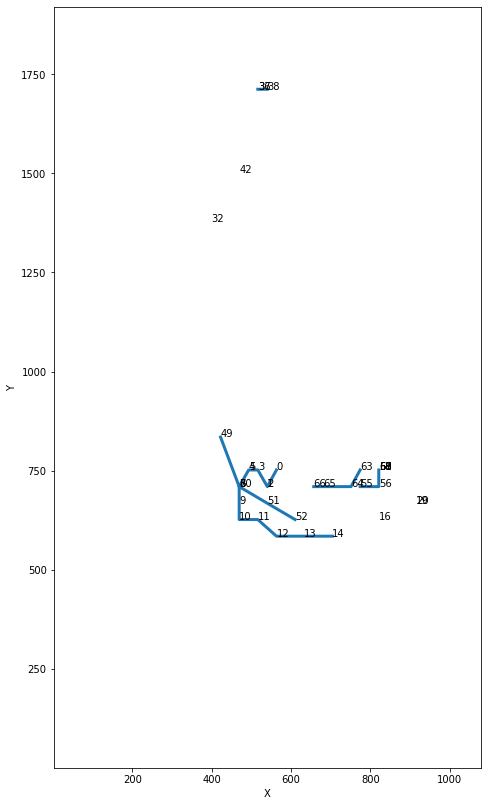

In [12]:
df_x = []
df_y = []

for points in df.loc[:, 7]:
    if points != None:
        x, y = points
        y = frame_height - y
    else:
        x = None
        y = None
    df_x.append(x)
    df_y.append(y)

plt.figure(figsize=(14,14))

plt.plot(df_x, df_y, linewidth=3)
plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df)):
    if df_x[i]!=None:
        plt.text(x=df_x[i], y=df_y[i], s=str(i))

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

plt.xlabel("X")
plt.ylabel("Y")

Text(0, 0.5, 'Y')

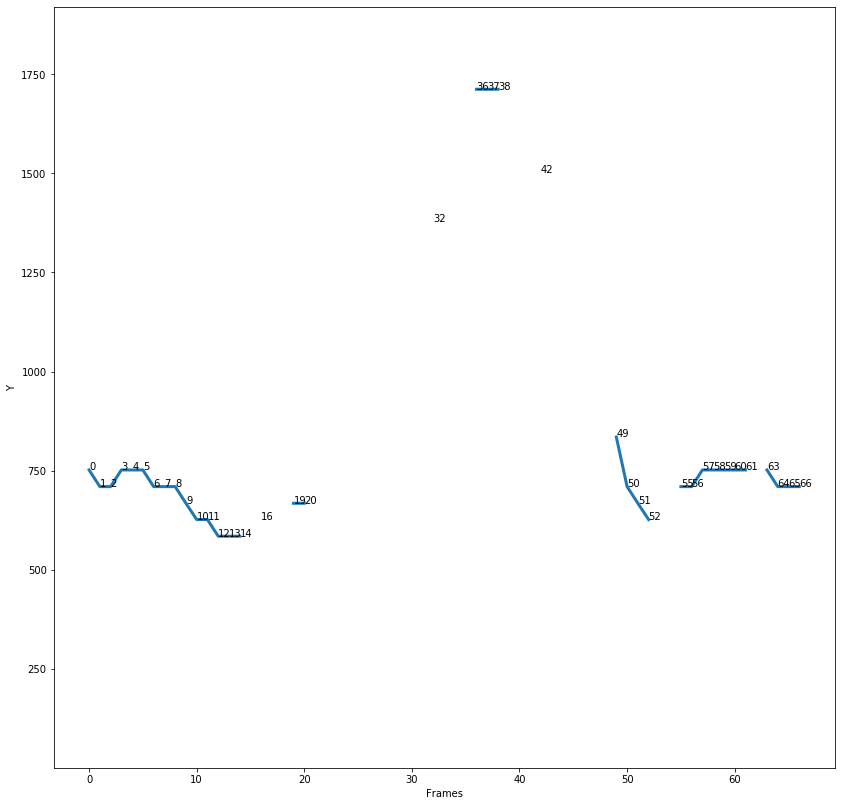

In [13]:
plt.figure(figsize=(14,14))

plt.plot(range(frame_counter-1), df_y, linewidth=3)
# plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df)):
    if df_x[i]!=None:
        plt.text(x=i, y=df_y[i], s=str(i))

# plt.gca().set_aspect('equal', adjustable='box')
# plt.draw()

plt.xlabel("Frames")
plt.ylabel("Y")

## Data Imputation

In [14]:
orient = "left"

In [15]:
vjump_points = [0, 1, 8]

if orient == "left":
    vjump_points.extend([5, 6, 7, 12, 13, 14])
elif orient == "right":
    vjump_points.extend([2, 3, 4, 9, 10, 11])

sorted(vjump_points)

[0, 1, 5, 6, 7, 8, 12, 13, 14]

In [16]:
df_imputed = df[vjump_points].copy()
df_imputed.head(40)

,0,1,8,5,6,7,12,13,14
1,"(516, 709)","(610, 793)","(633, 1168)","(610, 793)","(610, 1001)","(563, 1168)","(657, 1168)","(633, 1460)","(657, 1711)"
2,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
3,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
4,"(493, 709)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(516, 1168)","(680, 1168)","(610, 1377)","(633, 1711)"
5,"(493, 709)","(586, 793)","(657, 1126)","(610, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(586, 1377)","(633, 1711)"
6,"(493, 709)","(586, 834)","(657, 1126)","(586, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(563, 1377)","(633, 1711)"
7,"(493, 709)","(563, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)","(563, 1419)","(633, 1711)"
8,"(493, 751)","(586, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
9,"(469, 751)","(586, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
10,"(469, 751)","(563, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1252)","(704, 1168)","(516, 1419)","(633, 1753)"


In [17]:
def find_break_in_series(points_series, start_i):
    
    break_start_i = start_i - 1
    break_end_i = start_i
    break_found = False
    continue_crawling = True
    
    while (continue_crawling == True) and (break_end_i < points_series.index[-1]):
    
        if points_series[break_end_i] != None:
            break_found = False
            break_start_i = break_end_i
            break_end_i += 1
            
        else:
            break_found = True
            # break_end_i += 1
            
            while (break_found == True) and (break_end_i <= points_series.index[-1]):
                
                if points_series[break_end_i] == None:
                    break_end_i += 1
                else:
                    break_found = False
                    
            continue_crawling = False
        
    return break_start_i, break_end_i

def impute_break_in_series(points_series, start_i, end_i):
    
    diff = end_i - start_i
    start_x, start_y = points_series[start_i]
    end_x, end_y = points_series[end_i]
    
    diff_x = (end_x - start_x) / diff
    diff_y = (end_y - start_y) / diff
    
    multiplier = 1
    
    for i in range(start_i+1, end_i):
        x = int(round(start_x + (diff_x * multiplier)))
        y = int(round(start_y + (diff_y * multiplier)))
        points_series[i] = (x, y)
        multiplier += 1

def imputing_missing_points(points_series):
    
    series_start_i = points_series.index[0]
    series_end_i = points_series.index[-1]
    
    current_i = series_start_i
    
    while current_i < series_end_i:
        
        if points_series[current_i] == None:
            current_i += 1
            
        else:
            break_start_i, break_end_i = find_break_in_series(points_series, current_i)
            
            if break_end_i - break_start_i == 1:
                break
            elif break_end_i > series_end_i:
                break
            else: 
                impute_break_in_series(points_series, break_start_i, break_end_i)
                current_i = break_end_i
    
    return points_series

In [18]:
for i in vjump_points:
    df_imputed[i] = imputing_missing_points(df_imputed[i])

In [19]:
df_imputed.head(40)

,0,1,8,5,6,7,12,13,14
1,"(516, 709)","(610, 793)","(633, 1168)","(610, 793)","(610, 1001)","(563, 1168)","(657, 1168)","(633, 1460)","(657, 1711)"
2,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
3,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
4,"(493, 709)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(516, 1168)","(680, 1168)","(610, 1377)","(633, 1711)"
5,"(493, 709)","(586, 793)","(657, 1126)","(610, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(586, 1377)","(633, 1711)"
6,"(493, 709)","(586, 834)","(657, 1126)","(586, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(563, 1377)","(633, 1711)"
7,"(493, 709)","(563, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)","(563, 1419)","(633, 1711)"
8,"(493, 751)","(586, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
9,"(469, 751)","(586, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
10,"(469, 751)","(563, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1252)","(704, 1168)","(516, 1419)","(633, 1753)"


Text(266.26925221469514, 0.5, 'Y')

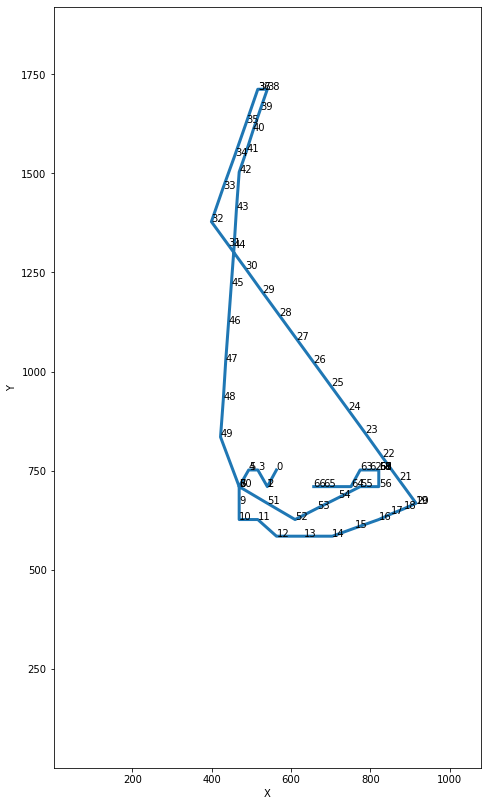

In [20]:
df_x = []
df_y = []

for points in df_imputed.loc[:, 7]:
    if points != None:
        x, y = points
        y = frame_height - y
    else:
        x = None
        y = None
    df_x.append(x)
    df_y.append(y)

plt.figure(figsize=(14,14))

plt.plot(df_x, df_y, linewidth=3)
plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df_imputed)):
    if df_x[i]!=None:
        plt.text(x=df_x[i], y=df_y[i], s=str(i))

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

plt.xlabel("X")
plt.ylabel("Y")

Text(0, 0.5, 'Y')

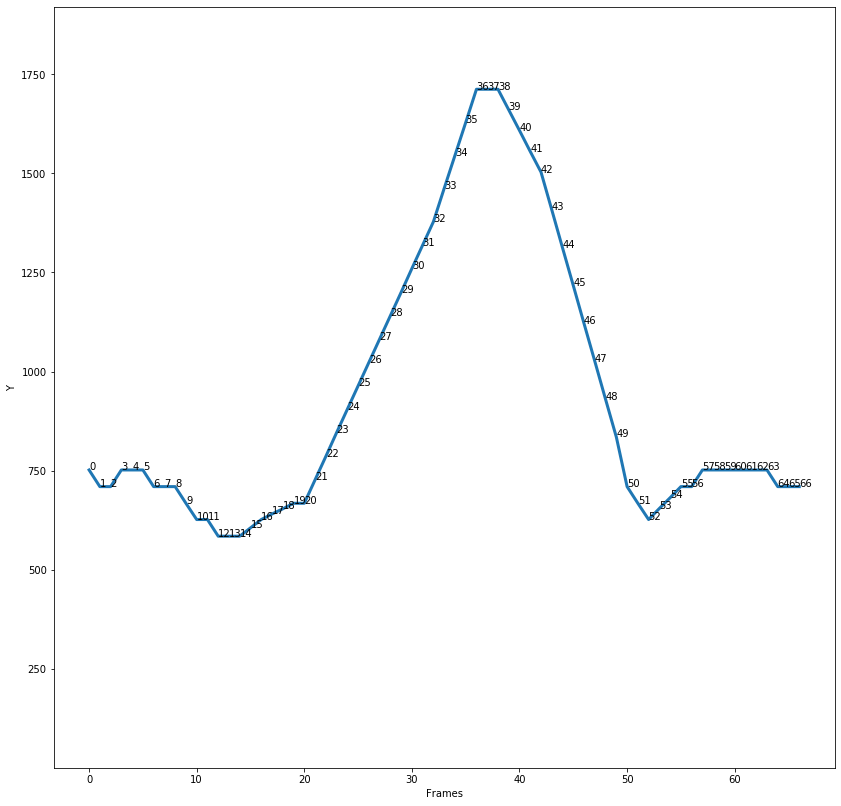

In [21]:
plt.figure(figsize=(14,14))

plt.plot(range(frame_counter-1), df_y, linewidth=3)
# plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df_imputed)):
    if df_x[i]!=None:
        plt.text(x=i, y=df_y[i], s=str(i))

plt.xlabel("Frames")
plt.ylabel("Y")

In [22]:
def overlay_imputed_skeleton(frame, points_row_imputed, points_row_original, frame_counter):

    frame_copy = np.copy(frame)

    for i in points_row_imputed.index:
        
        if points_row_imputed[i] != None:
            
            if points_row_original[i] != None:
        
                cv2.circle(frame_copy, points_row_imputed[i], 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            
            else:
                
                cv2.circle(frame_copy, points_row_imputed[i], 5, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frame_copy, f"{i}", points_row_imputed[i], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)
                
        cv2.putText(frame_copy, f"frame = {frame_counter}", (10, frame_height-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
                
    return frame_copy

In [23]:
# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_AGE.mp4"

def new_imputed_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_WITH_IMPUTED_BODY_POINTS"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

In [24]:
%%time

# Reading the video from filepath provided above and passing it through the age clasification method defined above.
# Source 1: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
# Source 2: https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

# Getting the video frame width and height.
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))

# Defining the codec and creating a VideoWriter object to save the output video at the same location.
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_imputed_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (frame_width, frame_height))

# Defining a new dataframe to store the skeleton point coordinates from each frame of the video.
frame_counter = 1

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        # Running human skeleton points detection on the grabbed frame.
        skeleton_frame = overlay_imputed_skeleton(frame, df_imputed.loc[frame_counter], df.loc[frame_counter], frame_counter)
        
        # Saving frame to output video using the VideoWriter object defined above.
        out.write(skeleton_frame)
        
        # Displaying the frame with age detected.
        cv2.imshow("Output Video", skeleton_frame)
        
        # Saving frame output skeleton point coordinates as a new row in above defined dataframe.
        # video_points_df[frame_counter] = skeleton_frame_points
        frame_counter += 1
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Releasing the VideoCapture and VideoWriter objects, and closing the displayed frame.
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Saved to {new_my_video}")

Saved to ../inputs_outputs/videos\vertical_jump_side_trial_1_WITH_IMPUTED_BODY_POINTS.mp4
Wall time: 3.15 s


## Data Points Normalization

In [25]:
df_imputed_norm = df_imputed.copy()

In [26]:
df_imputed_norm.head(40)

,0,1,8,5,6,7,12,13,14
1,"(516, 709)","(610, 793)","(633, 1168)","(610, 793)","(610, 1001)","(563, 1168)","(657, 1168)","(633, 1460)","(657, 1711)"
2,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
3,"(516, 667)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)","(633, 1419)","(633, 1711)"
4,"(493, 709)","(610, 793)","(657, 1168)","(610, 793)","(586, 1001)","(516, 1168)","(680, 1168)","(610, 1377)","(633, 1711)"
5,"(493, 709)","(586, 793)","(657, 1126)","(610, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(586, 1377)","(633, 1711)"
6,"(493, 709)","(586, 834)","(657, 1126)","(586, 793)","(563, 1001)","(493, 1168)","(680, 1126)","(563, 1377)","(633, 1711)"
7,"(493, 709)","(563, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)","(563, 1419)","(633, 1711)"
8,"(493, 751)","(586, 834)","(680, 1168)","(586, 834)","(563, 1043)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
9,"(469, 751)","(586, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1210)","(704, 1168)","(540, 1419)","(633, 1711)"
10,"(469, 751)","(563, 876)","(680, 1168)","(586, 876)","(540, 1085)","(469, 1252)","(704, 1168)","(516, 1419)","(633, 1753)"


In [27]:
origin_point = 0

In [28]:
def normalizing_body_points(row):
    
    if row[origin_point] == None:
        return row
    
    origin_x, origin_y = row[origin_point]
    
    for i in row.index:
        
        if i == origin_point:
            norm_x = 0.0
            norm_y = 0.0
            row[i] = (norm_x, norm_y)
            
        elif row[i] == None:
            pass
        
        else:
            i_x, i_y = row[i]
            norm_x = (i_x - origin_x) / frame_width
            norm_y = (i_y - origin_y) / frame_height
            norm_y = -1 * norm_y
            row[i] = (norm_x, norm_y)
    
    return row

In [29]:
for i in df_imputed_norm.index:
    df_imputed_norm.loc[i] = normalizing_body_points(df_imputed_norm.loc[i])

In [30]:
df_imputed_norm.head(40)

,0,1,8,5,6,7,12,13,14
1,"(0.0, 0.0)","(0.08703703703703704, -0.04375)","(0.10833333333333334, -0.2390625)","(0.08703703703703704, -0.04375)","(0.08703703703703704, -0.15208333333333332)","(0.04351851851851852, -0.2390625)","(0.13055555555555556, -0.2390625)","(0.10833333333333334, -0.39114583333333336)","(0.13055555555555556, -0.521875)"
2,"(0.0, 0.0)","(0.08703703703703704, -0.065625)","(0.13055555555555556, -0.2609375)","(0.08703703703703704, -0.065625)","(0.06481481481481481, -0.17395833333333333)","(0.022222222222222223, -0.2828125)","(0.13055555555555556, -0.2609375)","(0.10833333333333334, -0.39166666666666666)","(0.10833333333333334, -0.54375)"
3,"(0.0, 0.0)","(0.08703703703703704, -0.065625)","(0.13055555555555556, -0.2609375)","(0.08703703703703704, -0.065625)","(0.06481481481481481, -0.17395833333333333)","(0.022222222222222223, -0.2828125)","(0.13055555555555556, -0.2609375)","(0.10833333333333334, -0.39166666666666666)","(0.10833333333333334, -0.54375)"
4,"(0.0, 0.0)","(0.10833333333333334, -0.04375)","(0.15185185185185185, -0.2390625)","(0.10833333333333334, -0.04375)","(0.08611111111111111, -0.15208333333333332)","(0.021296296296296296, -0.2390625)","(0.17314814814814813, -0.2390625)","(0.10833333333333334, -0.34791666666666665)","(0.12962962962962962, -0.521875)"
5,"(0.0, 0.0)","(0.08611111111111111, -0.04375)","(0.15185185185185185, -0.2171875)","(0.10833333333333334, -0.04375)","(0.06481481481481481, -0.15208333333333332)","(0.0, -0.2390625)","(0.17314814814814813, -0.2171875)","(0.08611111111111111, -0.34791666666666665)","(0.12962962962962962, -0.521875)"
6,"(0.0, 0.0)","(0.08611111111111111, -0.06510416666666667)","(0.15185185185185185, -0.2171875)","(0.08611111111111111, -0.04375)","(0.06481481481481481, -0.15208333333333332)","(0.0, -0.2390625)","(0.17314814814814813, -0.2171875)","(0.06481481481481481, -0.34791666666666665)","(0.12962962962962962, -0.521875)"
7,"(0.0, 0.0)","(0.06481481481481481, -0.06510416666666667)","(0.17314814814814813, -0.2390625)","(0.08611111111111111, -0.06510416666666667)","(0.06481481481481481, -0.17395833333333333)","(-0.022222222222222223, -0.2609375)","(0.17314814814814813, -0.2390625)","(0.06481481481481481, -0.3697916666666667)","(0.12962962962962962, -0.521875)"
8,"(0.0, 0.0)","(0.08611111111111111, -0.043229166666666666)","(0.17314814814814813, -0.2171875)","(0.08611111111111111, -0.043229166666666666)","(0.06481481481481481, -0.15208333333333332)","(-0.022222222222222223, -0.2390625)","(0.19537037037037036, -0.2171875)","(0.04351851851851852, -0.34791666666666665)","(0.12962962962962962, -0.5)"
9,"(0.0, 0.0)","(0.10833333333333334, -0.06510416666666667)","(0.19537037037037036, -0.2171875)","(0.10833333333333334, -0.06510416666666667)","(0.06574074074074074, -0.17395833333333333)","(0.0, -0.2390625)","(0.2175925925925926, -0.2171875)","(0.06574074074074074, -0.34791666666666665)","(0.15185185185185185, -0.5)"
10,"(0.0, 0.0)","(0.08703703703703704, -0.06510416666666667)","(0.19537037037037036, -0.2171875)","(0.10833333333333334, -0.06510416666666667)","(0.06574074074074074, -0.17395833333333333)","(0.0, -0.2609375)","(0.2175925925925926, -0.2171875)","(0.04351851851851852, -0.34791666666666665)","(0.15185185185185185, -0.521875)"


In [31]:
df_imputed_norm.tail(40)

,0,1,8,5,6,7,12,13,14
28,"(0.0, 0.0)","(0.06574074074074074, -0.08697916666666666)","(0.17407407407407408, -0.2390625)","(0.08703703703703704, -0.08697916666666666)","(-0.04351851851851852, -0.15208333333333332)","(0.13425925925925927, -0.0234375)","(0.19537037037037036, -0.2390625)","(0.0, -0.34739583333333335)","(0.15185185185185185, -0.478125)"
29,"(0.0, 0.0)","(0.06574074074074074, -0.08697916666666666)","(0.17407407407407408, -0.2390625)","(0.08703703703703704, -0.08697916666666666)","(-0.04351851851851852, -0.10885416666666667)","(0.09444444444444444, -0.014583333333333334)","(0.19537037037037036, -0.2390625)","(0.022222222222222223, -0.34791666666666665)","(0.15185185185185185, -0.5)"
30,"(0.0, 0.0)","(0.08703703703703704, -0.06510416666666667)","(0.17407407407407408, -0.2390625)","(0.08703703703703704, -0.06510416666666667)","(-0.04351851851851852, -0.06510416666666667)","(0.05462962962962963, -0.005729166666666666)","(0.19537037037037036, -0.2390625)","(0.04351851851851852, -0.3697916666666667)","(0.15185185185185185, -0.521875)"
31,"(0.0, 0.0)","(0.06574074074074074, -0.065625)","(0.17407407407407408, -0.2390625)","(0.08703703703703704, -0.065625)","(-0.06481481481481481, -0.04375)","(0.014814814814814815, 0.0036458333333333334)","(0.19537037037037036, -0.2390625)","(0.06574074074074074, -0.3697916666666667)","(0.15185185185185185, -0.54375)"
32,"(0.0, 0.0)","(0.06574074074074074, -0.06510416666666667)","(0.13055555555555556, -0.2390625)","(0.08703703703703704, -0.043229166666666666)","(-0.021296296296296296, -0.043229166666666666)","(-0.025, 0.013020833333333334)","(0.17407407407407408, -0.2390625)","(0.10833333333333334, -0.39114583333333336)","(0.13055555555555556, -0.5651041666666666)"
33,"(0.0, 0.0)","(0.04351851851851852, -0.06510416666666667)","(0.13055555555555556, -0.2390625)","(0.10833333333333334, -0.043229166666666666)","(-0.01574074074074074, -0.021875)","(-0.06481481481481481, 0.021875)","(0.17407407407407408, -0.2390625)","(0.15185185185185185, -0.39114583333333336)","(0.13055555555555556, -0.5432291666666667)"
34,"(0.0, 0.0)","(0.07592592592592592, -0.05416666666666667)","(0.14074074074074075, -0.228125)","(0.11851851851851852, -0.05416666666666667)","(0.0, 0.0109375)","(-0.027777777777777776, 0.0546875)","(0.16203703703703703, -0.228125)","(0.16203703703703703, -0.3802083333333333)","(0.14074074074074075, -0.5328125)"
35,"(0.0, 0.0)","(0.06481481481481481, -0.04375)","(0.15185185185185185, -0.21770833333333334)","(0.10833333333333334, -0.04375)","(0.01574074074074074, 0.04375)","(0.011111111111111112, 0.08697916666666666)","(0.17314814814814813, -0.21770833333333334)","(0.15185185185185185, -0.3697916666666667)","(0.17314814814814813, -0.54375)"
36,"(0.0, 0.0)","(0.06481481481481481, -0.065625)","(0.15185185185185185, -0.22864583333333333)","(0.08703703703703704, -0.04375)","(0.021296296296296296, 0.06510416666666667)","(0.03796296296296296, 0.10833333333333334)","(0.19537037037037036, -0.21770833333333334)","(0.12962962962962962, -0.3697916666666667)","(0.19537037037037036, -0.54375)"
37,"(0.0, 0.0)","(0.08703703703703704, -0.04375)","(0.17407407407407408, -0.21770833333333334)","(0.10925925925925926, -0.021875)","(0.04351851851851852, 0.08697916666666666)","(0.08703703703703704, 0.15208333333333332)","(0.2175925925925926, -0.21770833333333334)","(0.15185185185185185, -0.3697916666666667)","(0.2175925925925926, -0.54375)"


Text(94.45500000000001, 0.5, 'Y')

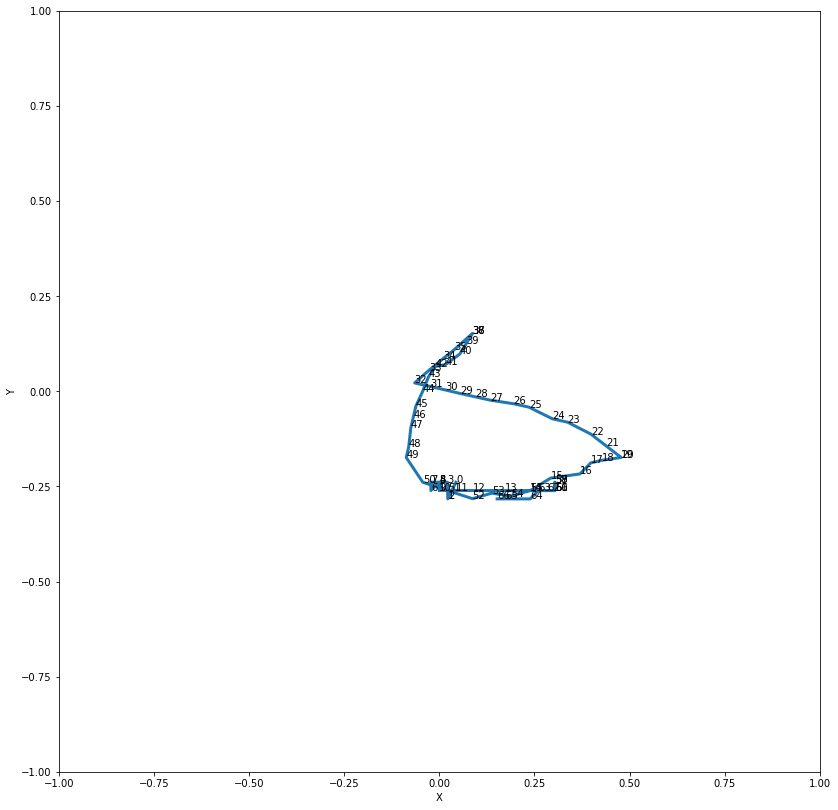

In [32]:
df_x = []
df_y = []

for points in df_imputed_norm.loc[:, 7]:
    if points != None:
        x, y = points
        # y = frame_height - y
    else:
        x = None
        y = None
    df_x.append(x)
    df_y.append(y)

plt.figure(figsize=(14,14))

plt.plot(df_x, df_y, linewidth=3)
plt.xlim([-1, 1])
plt.ylim([-1, 1])

for i in range(len(df_imputed_norm)):
    if df_x[i]!=None:
        plt.text(x=df_x[i], y=df_y[i], s=str(i))

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

plt.xlabel("X")
plt.ylabel("Y")

Text(0, 0.5, 'Y')

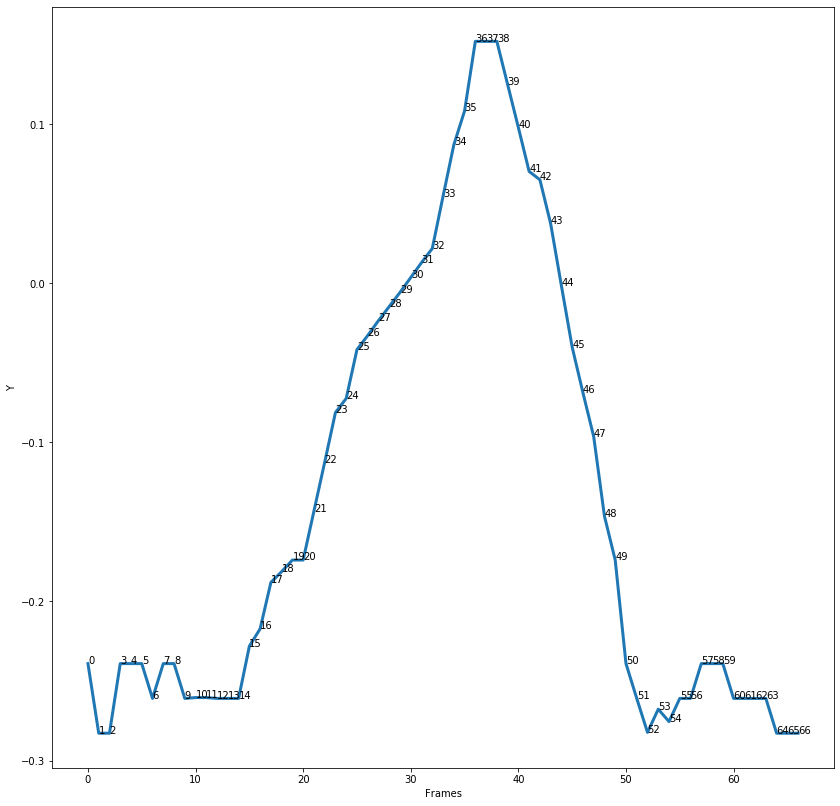

In [33]:
plt.figure(figsize=(14,14))

plt.plot(range(frame_counter-1), df_y, linewidth=3)
# plt.xlim([-0.5, 0.5])
# plt.ylim([-0.5, 0.5])

for i in range(len(df_imputed_norm)):
    if df_x[i]!=None:
        plt.text(x=i, y=df_y[i], s=str(i))

# plt.gca().set_aspect('equal', adjustable='box')
# plt.draw()

plt.xlabel("Frames")
plt.ylabel("Y")

In [34]:
def normalized_skeleton(points_row_norm, points_row_original, frame_counter):

    frame = cv2.imread("../inputs_outputs/white_frame.jpg")

    for i in points_row_norm.index:
        
        if points_row_norm[i] != None:
            
            x_norm, y_norm = points_row_norm[i]
            x_norm_sc = int(round(x_norm * 1000 + 1000))
            y_norm_sc = int(round(y_norm * 1000 + 1000))
            
            if points_row_original[i] != None:
        
                cv2.circle(frame, (x_norm_sc, y_norm_sc), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frame, f"{i}", (x_norm_sc, y_norm_sc), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            
            else:
                
                cv2.circle(frame, (x_norm_sc, y_norm_sc), 5, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frame, f"{i}", (x_norm_sc, y_norm_sc), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            
        cv2.putText(frame, f"frame = {frame_counter}", (10, 1990), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)
                
    return frame

In [35]:
# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_AGE.mp4"

def new_normalized_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_WITH_NORMALIZED_BODY_POINTS"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

In [36]:
%%time

# Reading the video from filepath provided above and passing it through the age clasification method defined above.
# Source 1: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
# Source 2: https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

# Getting the video frame width and height.
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))

# Defining the codec and creating a VideoWriter object to save the output video at the same location.
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_normalized_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (2000, 2000))

# Defining a new dataframe to store the skeleton point coordinates from each frame of the video.
frame_counter = 1

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        # Running human skeleton points detection on the grabbed frame.
        skeleton_frame = normalized_skeleton(df_imputed_norm.loc[frame_counter], df.loc[frame_counter], frame_counter)
        
        # Saving frame to output video using the VideoWriter object defined above.
        out.write(skeleton_frame)
        
        # Displaying the frame with age detected.
        cv2.imshow("Output Video", skeleton_frame)
        
        # Saving frame output skeleton point coordinates as a new row in above defined dataframe.
        # video_points_df[frame_counter] = skeleton_frame_points
        frame_counter += 1
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Releasing the VideoCapture and VideoWriter objects, and closing the displayed frame.
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Saved to {new_my_video}")

Saved to ../inputs_outputs/videos\vertical_jump_side_trial_1_WITH_NORMALIZED_BODY_POINTS.mp4
Wall time: 6.45 s
